# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [2]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Thomas Evers"
STUDENT_1_STUDENT_NUMBER = "5310121"
STUDENT_1_NETID = "thomasevers"
STUDENT_1_EMAIL = "t.evers-2@student.tudelft.nl"

In [28]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2a.1 - PD control (4p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

In [29]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import numpy as jnp
import os
from pathlib import Path

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
# define tolerances for grading
RTOL = float(os.environ.get("RTOL", "1e-4"))  # relative tolerance
ATOL = float(os.environ.get("ATOL", "1e-7"))  # absolute tolerance

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 2a.1.1 - Implementation and simulation of a PD feedback controller acting on the link angles (2p)
In this task, we regulate the link angles and angular velocities $\theta \in \mathbb{R}^2$, $\dot{\theta} \in \mathbb{R}^2$ towards the desired trajectory $\theta^\mathrm{d} \in \mathbb{R}^2$, $\dot{\theta}^\mathrm{d} \in \mathbb{R}^2$. The PD control law is given by:

\begin{equation}
\tau_\mathrm{fb} = k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta})
\end{equation}

### Implementing `ctrl_fb_pd` (0.5p)
Please implement the specified PD controller into the function `ctrl_fb_pd` in the notebook `controllers.ipynb`. 

In [30]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import ctrl_fb_pd function from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd

# test output shape of ctrl_fb_pd
_tau_dummy = ctrl_fb_pd(
    jnp.ones((2,)),
    jnp.ones((2,)),
    jnp.zeros((2,)),
    jnp.zeros((2,)),
    kp=jnp.eye(2),
    kd=jnp.eye(2),
)
print("Computed torque:", _tau_dummy, "Nm")
assert _tau_dummy.shape == (2,), "The computed torque needs to be of shape (2, )"


Computed torque: [-2. -2.] Nm


### Simulating the closed-loop system (1.5p)

In this section, we apply the implemented PD controller to a closed-loop simulation. The goal is achieve an RMSE error for the end-effector position of just lower than 0.1m. Please tune the gain matrices `kp` and `kd` accordingly.

In [31]:
import sys
sys.path.append("C:/Users/thoma/OneDrive - Delft University of Technology/Documenten/UNI/Intelligent Control/ics-pa-sv")


In [32]:
from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# initial link angles (i.e. at the first time-step)
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

In [33]:
# controller parameters
# define the proportional gain matrix kp and the derivative gain matrix kd
kp = jnp.zeros((2, 2))
kd = jnp.zeros((2, 2))
kp = jnp.array([[3500, 0], [0, 3500]])
kd = jnp.array([[400, 0], [0, 400]])



Now, we simulate the robot for 10s and save the states and inputs throughout the simulation in the `sim_ts` dictionary. **Please make sure to study the usage and behaviour of the `partial` function, as it will be very relevant and often-used throughout the entire assignment.** You can find a nice tutorial for example [here](https://www.pythontutorial.net/python-basics/python-partial-functions/).

In [34]:
# simulate the robot with the given controller
sim_ts_link = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_fb=partial(ctrl_fb_pd, kp=kp, kd=kd),
)

# evaluate the control performance quantitatively
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts_link)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts_link)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.041 0.017] rad, RMSE theta_d: [0.077 0.136] rad/s, RMSE theta_dd: [0.462 6.367] rad/s^2
RMSE x: 0.0880 m, RMSE x_d: 0.253 m/s, RMSE x_dd: 6.52 m/s^2


In [35]:
# DO NOT REMOVE OR MODIFY THIS CELL

rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts_link)
print("Euclidean norm of RMSE x:\n", jnp.linalg.norm(rmse_x))

assert (
    jnp.linalg.norm(rmse_x) < 0.1
), "The end-effector position needs to be smaller than 0.1m."

Euclidean norm of RMSE x:
 0.08801761229760498


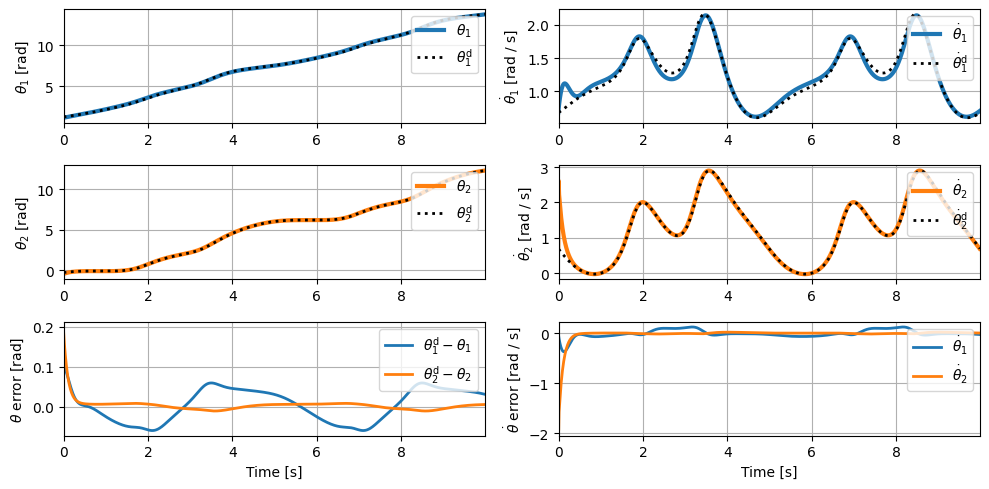

In [36]:
# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts_link,
    filepath=str(
        outputs_dir / "task_2a-1-1_configuration_space_trajectory_following.pdf"
    ),
)

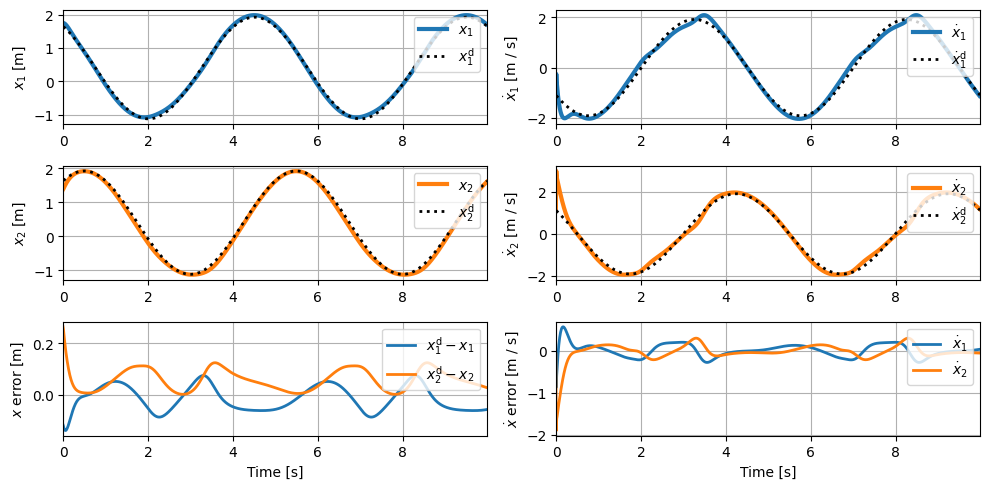

In [37]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts_link,
    filepath=str(
        outputs_dir / "task_2a-1-1_operational_space_trajectory_following.pdf"
    ),
)

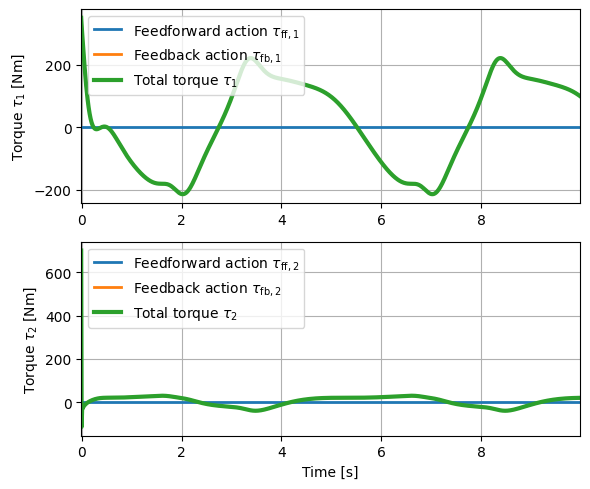

In [38]:
# plot the actuation sequence
plot_actuation(sim_ts_link, filepath=str(outputs_dir / "task_2a-1-1_actuation.pdf"))

In [39]:
if not AUTOGRADING:
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts_link,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2a-1-1_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))

## Task 2a.1.2 - Implementation and simulation of a PD feedback controller acting on the joint angles (1.5p)
In this task, we regulate the angles and angular velocities of the joints towards the desired values.
The joint angles describe the relative rotation between links. In the case of the double pendulum, they can be defined as

\begin{equation}
\theta_\mathrm{rel} = \begin{bmatrix}\theta_1\\ \theta_2 - \theta_1\end{bmatrix} \qquad \dot{\theta}_\mathrm{rel} = \begin{bmatrix}\dot{\theta}_1\\ \dot{\theta}_2 - \dot{\theta}_1\end{bmatrix}.
\end{equation}

The PD control law is then given by:

\begin{equation}
\tau_\mathrm{fb} = k_\mathrm{p} \, (\theta^\mathrm{d}_\mathrm{rel}-\theta_\mathrm{rel}) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}_\mathrm{rel}-\dot{\theta}_\mathrm{rel})
\end{equation}

### Implementing `ctrl_fb_pd_rel` (1.5p)
Please implement the specified PD controller into the function `ctrl_fb_pd_rel` in the notebook `controllers.ipynb`. 
**Hint:** Do not use `jnp.array()` in your implementation, but instead `jnp.stack`.

In [22]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import ctrl_fb_pd_rel function from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd_rel

# test output shape of ctrl_fb_pd_rel
_tau_dummy = ctrl_fb_pd_rel(
    jnp.ones((2,)),
    jnp.ones((2,)),
    jnp.zeros((2,)),
    jnp.zeros((2,)),
    kp=jnp.eye(2),
    kd=jnp.eye(2),
)
print("Computed torque:", _tau_dummy, "Nm")
assert _tau_dummy.shape == (2,), "The computed torque needs to be of shape (2, )"


Computed torque: [-2.  0.] Nm


### Simulating the closed-loop system (0p)

In this section, we apply the implemented PD controller acting on the joint angles to a closed-loop simulation. Please use the same gain matrices `kp` and `kd` as in Task 2a.1.1.

In [47]:
# simulate the robot with the given controller
sim_ts_joint = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_fb=partial(ctrl_fb_pd_rel, kp=kp, kd=kd),
)

# evaluate the control performance quantitatively
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts_joint) #Changed this line to sim_ts_joint
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts_joint)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.041 0.041] rad, RMSE theta_d: [0.076 0.119] rad/s, RMSE theta_dd: [0.466 3.05 ] rad/s^2
RMSE x: 0.0675 m, RMSE x_d: 0.190 m/s, RMSE x_dd: 3.26 m/s^2


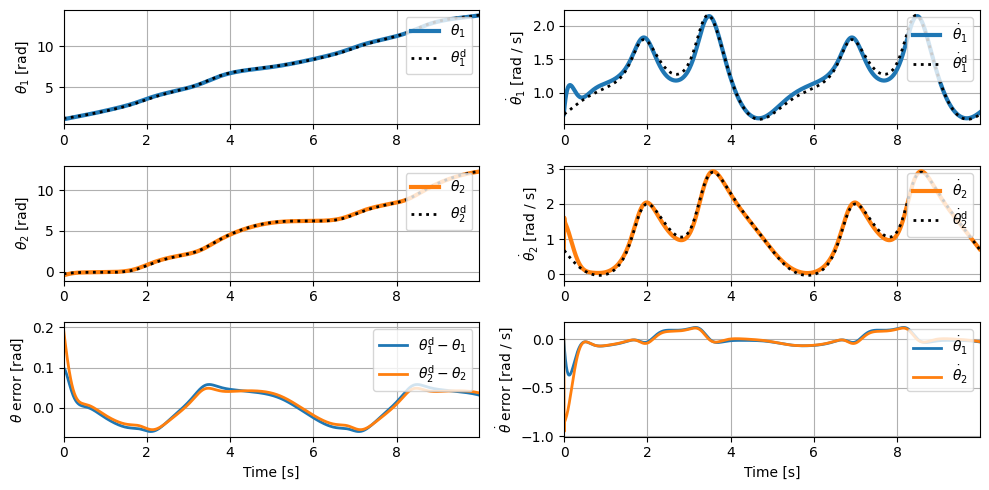

In [48]:
# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts_joint,
    filepath=str(
        outputs_dir / "task_2a-1-2_configuration_space_trajectory_following.pdf"
    ),
)

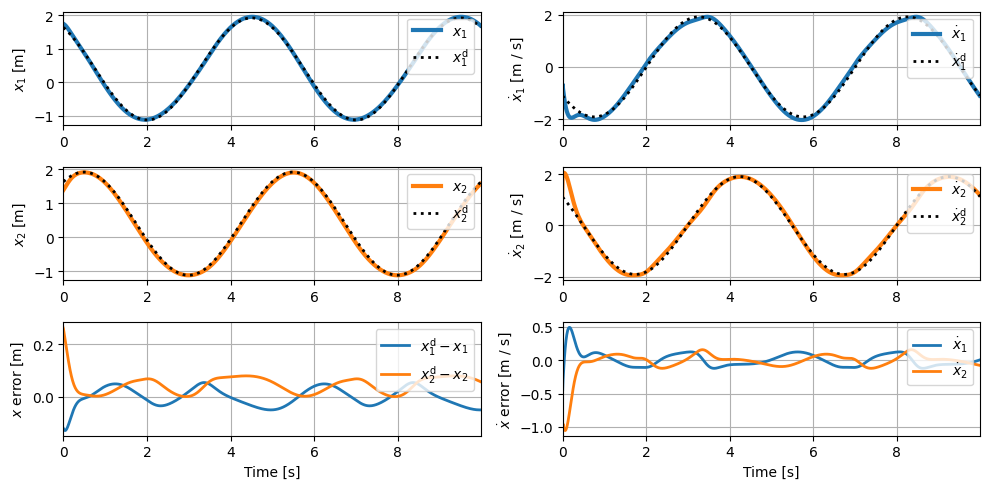

In [49]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts_joint,
    filepath=str(
        outputs_dir / "task_2a-1-2_operational_space_trajectory_following.pdf"
    ),
)

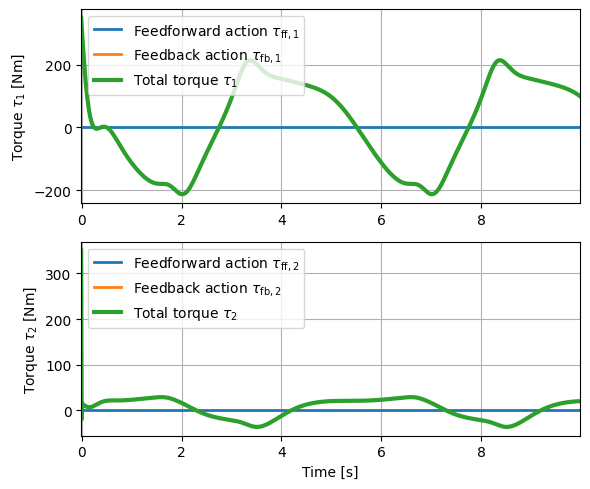

In [50]:
# plot the actuation sequence
plot_actuation(sim_ts_joint, filepath=str(outputs_dir / "task_2a-1-2_actuation.pdf"))

In [51]:
if not AUTOGRADING:
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts_joint,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2a-1-2_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))

## Task 2a.1.3 - Comparison of performance between PDs acting on the link and joint angles (0.5p)
Compare the performance between the two variants of the implemented PD law. Why is, for equal control gains, the performance of the PD acting on the joint (i.e., relative) angles better than the one acting on the link (i.e., absolute) angles?

**A:** The dynamics of the second link are considerably slower than the dynamics of the first link. Therefore, a PD acting on the link angles exhibits a more pronounced oscillatory behavior for the second link.

**B:** The dynamics of the second link are considerably faster than the dynamics of the first link. Therefore, a PD acting on the link angles exhibits a more pronounced oscillatory behavior for the second link.

**C:** The dynamics of the second link are considerably slower than the dynamics of the first link. Therefore, a PD acting on the link angles exhibits a more pronounced oscillatory behavior for the first link.

**D:** The dynamics of the second link are considerably faster than the dynamics of the first link. Therefore, a PD acting on the link angles exhibits a more pronounced oscillatory behavior for the first link.

In [53]:
# please write the answer ("A", "B", "C", or "D") into the `answer_1` variable
answer_1 = ("D")


In [ ]:
# DO NOT REMOVE OR MODIFY THIS CELL
assert answer_1 in ["A", "B", "C", "D"], 'Please answer "A", "B", "C", or "D"'
